# Setting up offshore wind farm layout
## For HFM FY2022 Q4 Milestone

### Option 2: 9 row staggered layout with IEA 15MW reference turbine

In [1]:
# Note: this python notebook was automatically generated by make_tutorial3.py

# Load the amrwind-frontend module
amrwindfedir = '/ascldap/users/lcheung/local/Git/amrwind-frontend/'  # Location of amrwind-frontend 
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

**Note**: Make sure to have the IEA15 Reference wind turbine defined somewhere by amrwind-frontend.  For instance in the `turbines/` subdirectory, create a YAML file with the contents:

In [2]:
with open(amrwindfedir+"turbines/IEA15MW_RWT.yaml")as f: print(f.read())

turbines:
  UnifCttest:
    turbinetype_name:    "IEA15_UnifCt"
    turbinetype_comment: "Test UnifCtDisk"
    Actuator_type:       UniformCtDisk
    Actuator_rotor_diameter:      240
    Actuator_hub_height:          150
    Actuator_thrust_coeff:        0.6
    Actuator_epsilon:             [5.0]



### Define turbine and farm properties

In [3]:
# Define some properties
rotorD = 240           # Rotor diameter
WS     = 10            # Wind speed, m/s
WDir   = 225           # Wind direction, degrees

# Farm properties
farm_rotate      = -45                          # Number of degrees to rotate turbine rows (relative to x-axis)
farm_domainsize  = [50000.0, 50000.0, 2000.0]   # Farm domain size
farm_background_mesh = 20.0                     # Background mesh size [meters]

In [4]:
# Define the farm properties

# ==== 7 x 7 turbine arrangement ====
"""
farm_title       = 'IEA 15MW, 7x7 row square arrangement'
# Turbine spacing
turb_LatSpacing  = 3   # lateral spacing, diameters
turb_LongSpacing = 8   # longitudinal spacing, diameters
# Define the rows
farmrowdict = [{'Nturb':7, 'rowoffset':0},
               {'Nturb':7, 'rowoffset':0},
               {'Nturb':7, 'rowoffset':0},
               {'Nturb':7, 'rowoffset':0},
               {'Nturb':7, 'rowoffset':0},
               {'Nturb':7, 'rowoffset':0},
               {'Nturb':7, 'rowoffset':0},
              ]
""";
# ==== 50 turbine staggered arrangement ====
farm_title       = 'IEA 15MW, 50 turbine staggered arrangement'
# Turbine spacing
turb_LatSpacing  = 3   # lateral spacing, diameters
turb_LongSpacing = 4   # longitudinal spacing, diameters
# Define the rows
farmrowdict = [{'Nturb':6, 'rowoffset':0},
               {'Nturb':5, 'rowoffset':1.5},
               {'Nturb':6, 'rowoffset':0},
               {'Nturb':5, 'rowoffset':1.5},
               {'Nturb':6, 'rowoffset':0},
               {'Nturb':5, 'rowoffset':1.5},
               {'Nturb':6, 'rowoffset':0},
               {'Nturb':5, 'rowoffset':1.5},
               {'Nturb':6, 'rowoffset':0},
              ]

### Setup farm layout

In [5]:
# Rotates a point pt about origin orig   
# Here theta is measured w.r.t. the x-axis
def rotatepoint(pt, orig, theta):
    dx = pt[0]-orig[0]
    dy = pt[1]-orig[1]
    p2=[0.0, 0.0]
    p2[0] = dx*math.cos(theta) - dy*math.sin(theta) + orig[0]
    p2[1] = dx*math.sin(theta) + dy*math.cos(theta) + orig[1]
    return p2

In [6]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [7]:
case.setAMRWindInput('useWSDir', True)
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)
case.setAMRWindInput('ABL_winddir',   WDir, forcechange=True)
case.ABL_calculateWindVector()

In [8]:
# Some random stuff
case.setAMRWindInput('incflo.physics', ['FreeStream', 'Actuator'])
case.setAMRWindInput('time.fixed_dt', 0.1)

In [9]:
# Build the wind farm turbine positions
farmturb_xy = []
for irow, row in enumerate(farmrowdict):
    turb_y = irow*turb_LongSpacing*rotorD
    for iturb in range(row['Nturb']):
        turb_x = iturb*turb_LatSpacing*rotorD + row['rowoffset']*rotorD
        farmturb_xy.append([turb_x, turb_y])
farmturb_xy = np.array(farmturb_xy)

print("Total turbines = "+repr(len(farmturb_xy)))

Total turbines = 50


In [10]:
# Recenter the farm to be at the origin
farmturb_orig = np.mean(farmturb_xy, axis=0)
farmturb_xy = np.array([x-farmturb_orig for x in farmturb_xy])
farmturb_xy = np.array([rotatepoint(pt, [0.0, 0.0], farm_rotate*np.pi/180.0) for pt in farmturb_xy])

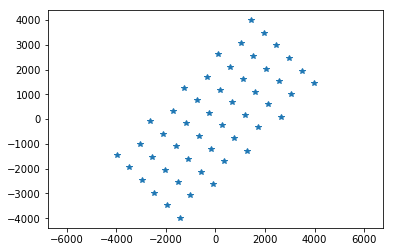

In [11]:
# Test plot
plt.plot(farmturb_xy[:,0], farmturb_xy[:,1], '*')
plt.axis('equal');

In [12]:
# Build the CSV input file of turbine layouts for amrwind-frontend
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%02i, %f, %f, IEA15_UnifCt, , ,\n"
for iturb, xy in enumerate(farmturb_xy):
    turbinescsv += rowformat%(iturb, xy[0], xy[1])
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [13]:
# Set up the domain 
case.setAMRWindInput('turbines_domainsize', farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_deleteprev', True)

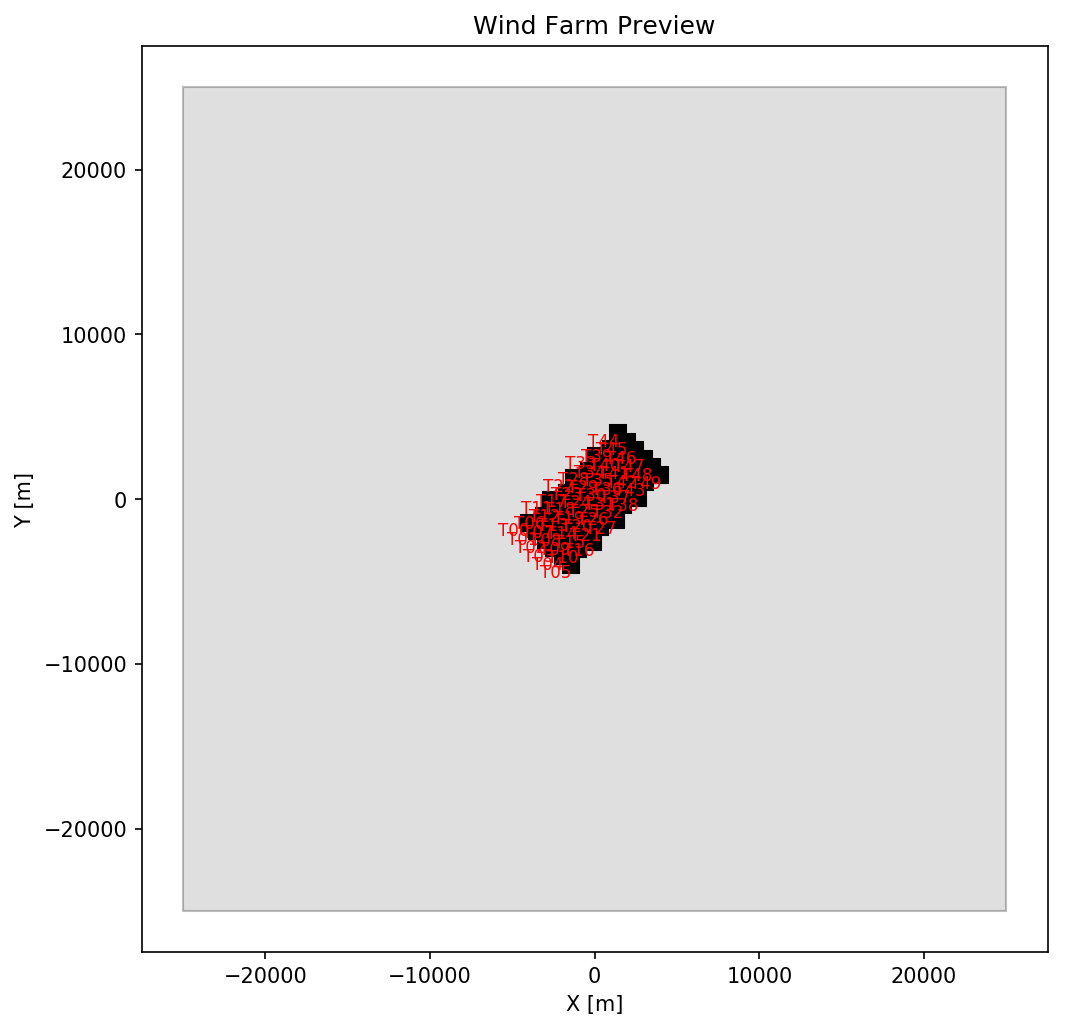

In [14]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [15]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()
['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48', 'T49']


### Add mesh refinement

In [16]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     40,   40,  25,  0.62,  2,     center:farm
1,     2,    2,   1,   0.55,  0.6,
2,     0.5,  0.5, 0.5, 0.525, 0.525,
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [17]:
case.refine_createAllZones()
# Print out existing list of turbines
#print(case.listboxpopupwindict['listboxtagging'].getitemlist())

Plotting turbines


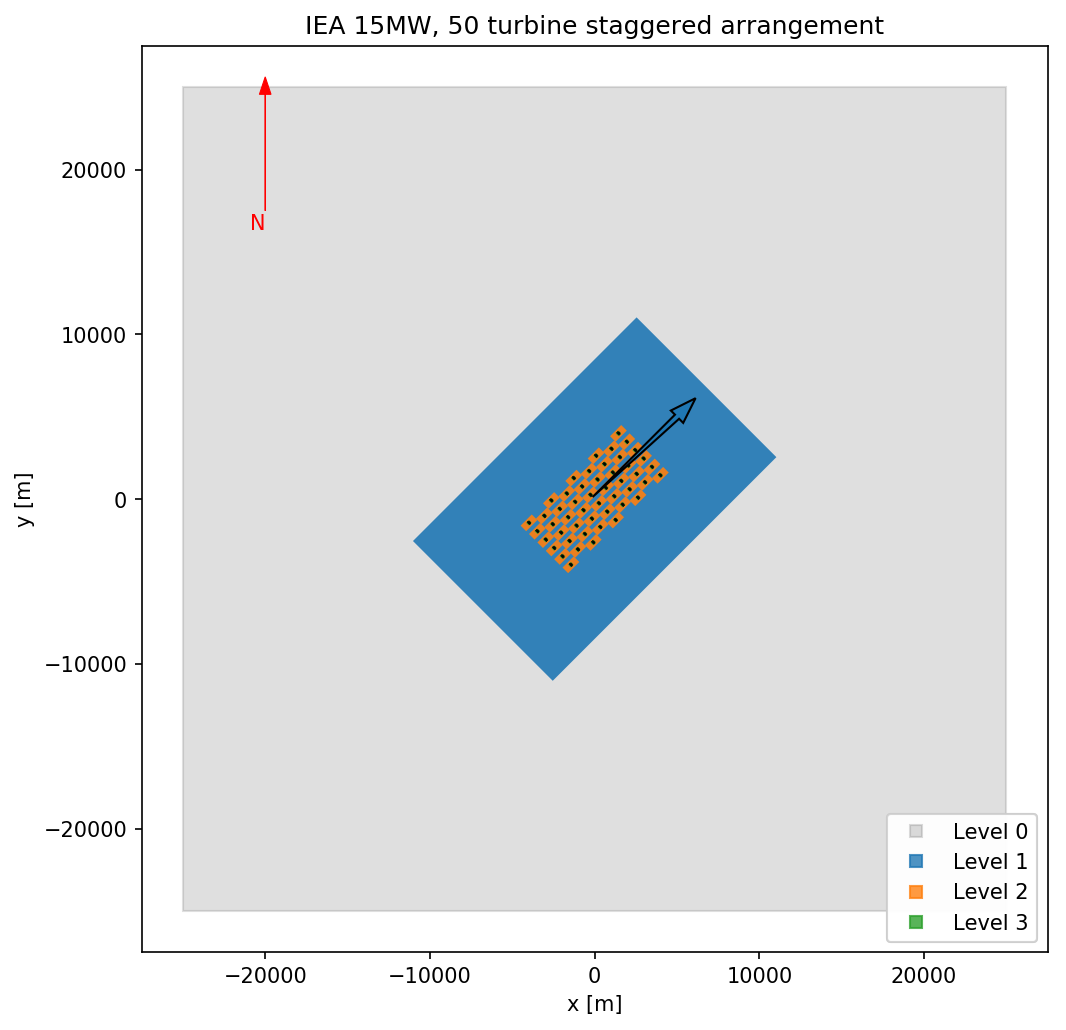

In [18]:
# Plot the domain (total domain)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = True
case.plotDomain(ax=ax)
ax.axis('scaled')
#ax.set_xlim([-10000,10000])
#ax.set_ylim([-10000,10000])
ax.set_title(farm_title)

Plotting turbines


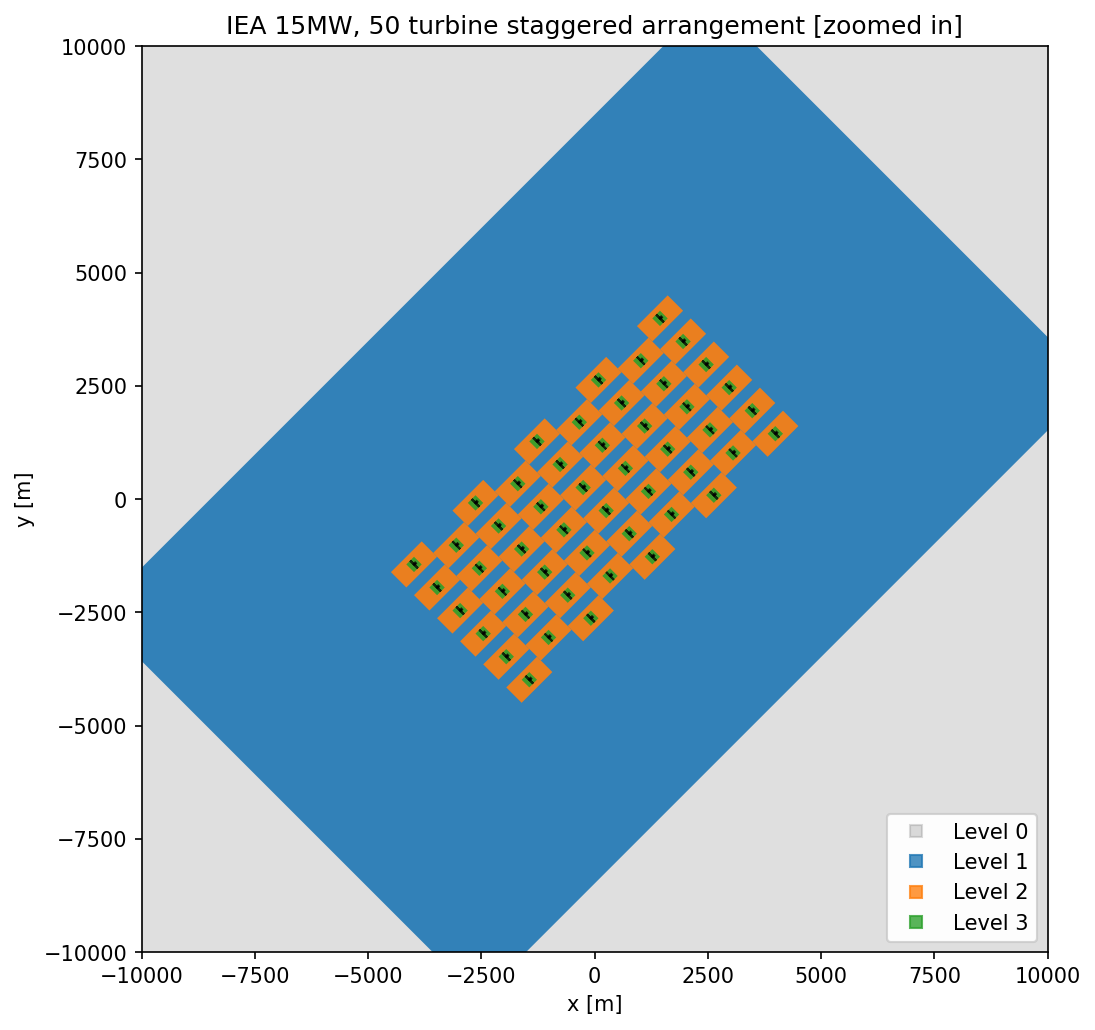

In [19]:
# Plot the domain (zoomed-in)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.plotDomain(ax=ax)
ax.axis('scaled')
ax.set_xlim([-10000,10000])
ax.set_ylim([-10000,10000])
ax.set_title(farm_title+' [zoomed in]')

### Estimate mesh size

In [20]:
# Estimate mesh size
case.estimateMeshSize()

Refinement Farm_level_0_zone: level 1: 144875520 cells
Refinement T00_level_1_zone: level 2: 1017446 cells
Refinement T01_level_1_zone: level 2: 1017446 cells
Refinement T02_level_1_zone: level 2: 1017446 cells
Refinement T03_level_1_zone: level 2: 1017446 cells
Refinement T04_level_1_zone: level 2: 1017446 cells
Refinement T05_level_1_zone: level 2: 1017446 cells
Refinement T06_level_1_zone: level 2: 1017446 cells
Refinement T07_level_1_zone: level 2: 1017446 cells
Refinement T08_level_1_zone: level 2: 1017446 cells
Refinement T09_level_1_zone: level 2: 1017446 cells
Refinement T10_level_1_zone: level 2: 1017446 cells
Refinement T11_level_1_zone: level 2: 1017446 cells
Refinement T12_level_1_zone: level 2: 1017446 cells
Refinement T13_level_1_zone: level 2: 1017446 cells
Refinement T14_level_1_zone: level 2: 1017446 cells
Refinement T15_level_1_zone: level 2: 1017446 cells
Refinement T16_level_1_zone: level 2: 1017446 cells
Refinement T17_level_1_zone: level 2: 1017446 cells
Refinemen